In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly as py
from plotly import tools
from plotly.offline import iplot
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns
from math import sqrt
import statsmodels.api as sm
#from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools  import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acovf, acf
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#Graph Settings
plt.rcParams['figure.figsize'] = (15,4)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 14

In [4]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.9 MB/s eta 0:00:00


In [5]:
from pmdarima import auto_arima

In [11]:
dt = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pakistan Largest Ecommerce Dataset.csv', parse_dates=["created_at", "Working Date"], low_memory=False)

In [8]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33457 entries, 0 to 33456
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   item_id                33457 non-null  int64  
 1   status                 33457 non-null  object 
 2   created_at             33457 non-null  object 
 3   sku                    33455 non-null  object 
 4   price                  33457 non-null  float64
 5   qty_ordered            33457 non-null  int64  
 6   grand_total            33457 non-null  float64
 7   increment_id           33457 non-null  int64  
 8   category_name_1        33457 non-null  object 
 9   sales_commission_code  33457 non-null  object 
 10  discount_amount        33457 non-null  float64
 11  payment_method         33457 non-null  object 
 12  Working Date           33457 non-null  object 
 13  BI Status              33456 non-null  object 
 14   MV                    33456 non-null  object 
 15  Ye

In [9]:
dt.rename(columns = {' MV ':'MV'}, inplace = True)
#Droping Null Columns
dt = dt.iloc[:, :-5]
dt = dt.dropna(how = 'all')
dt.columns

Index(['item_id', 'status', 'created_at', 'sku', 'price', 'qty_ordered',
       'grand_total', 'increment_id', 'category_name_1',
       'sales_commission_code', 'discount_amount', 'payment_method',
       'Working Date', 'BI Status', 'MV', 'Year', 'Month', 'Customer Since',
       'M-Y', 'FY', 'Customer ID'],
      dtype='object')

In [ ]:
#Casting on Data types
dt['Customer ID'] = dt['Customer ID'].astype(str)
dt['item_id'] = dt['item_id'].astype(str)
dt['qty_ordered'] = dt['qty_ordered'].astype(int)
dt['Year'] = dt['Year'].astype(int)
dt['Month'] = dt['Month'].astype(int)

In [10]:
#Data Summary
dt.describe()

,item_id,price,qty_ordered,grand_total,increment_id,discount_amount,Year,Month,Customer ID
count,33457.000000,33457.000000,33457.000000,3.345700e+04,3.345700e+04,33457.000000,33456.0,33456.000000,33456.000000
mean,231821.890965,4049.121150,1.135188,5.323016e+03,1.001615e+08,122.044743,2016.0,8.126943,3138.719183
std,12233.362288,11445.439038,1.160659,2.354588e+04,8.237760e+03,774.207003,0.0,0.799452,3047.117182
min,211131.000000,0.000000,1.000000,0.000000e+00,1.001474e+08,0.000000,2016.0,7.000000,1.000000
25%,220575.000000,285.000000,1.000000,3.350000e+02,1.001543e+08,0.000000,2016.0,7.000000,352.000000
50%,232251.000000,520.000000,1.000000,7.992000e+02,1.001617e+08,0.000000,2016.0,8.000000,2136.000000
75%,242678.000000,1605.000000,1.000000,2.695000e+03,1.001686e+08,0.000000,2016.0,9.000000,5544.000000
max,252572.000000,235000.000000,130.000000,1.280473e+06,1.001758e+08,33750.000000,2016.0,9.000000,9780.000000


In [12]:
dt = dt.sort_values('created_at')

In [13]:
#Adding New Features
dtg = dt.groupby('created_at')['grand_total'].sum().reset_index()
dtq = dt.groupby('created_at')['qty_ordered'].sum().reset_index()
dtd = dt.groupby('created_at')['discount_amount'].sum().reset_index()

In [14]:
#Comput count for non numeric values
dts = dt.groupby('created_at')['sku'].count().reset_index()
dtst = dt.groupby('created_at')['status'].count().reset_index()

In [17]:
# new data set
p = pd.DataFrame(dtg)
p['qty_ordered'] = dtq['qty_ordered']
p['discount_amount'] = dtd['discount_amount']
p['sku'] = dts['sku']
p['status'] = dtst['status']

In [18]:
#Cumulative Sum
p['cum_grand_total'] = p['grand_total'].cumsum()
p['cum_qty_ordered'] = p['qty_ordered'].cumsum()
p['cum_discount_amount'] = p['discount_amount'].cumsum()
p['cum_sku_cnt'] = p['sku'].cumsum()
p['cum_status_cnt'] = p['status'].cumsum()


In [19]:
p

,created_at,grand_total,qty_ordered,discount_amount,sku,status,cum_grand_total,cum_qty_ordered,cum_discount_amount,cum_sku_cnt,cum_status_cnt
0,2016-07-01,1301026.75,621,8100.00,547,547,1.301027e+06,621,8100.00,547,547
1,2016-07-02,1408450.48,301,2502.00,260,260,2.709477e+06,922,10602.00,807,807
2,2016-07-03,2215490.88,264,1501.00,210,210,4.924968e+06,1186,12103.00,1017,1017
3,2016-07-04,1094080.25,263,4406.00,229,229,6.019048e+06,1449,16509.00,1246,1246
4,2016-07-05,913053.50,194,5230.00,168,168,6.932102e+06,1643,21739.00,1414,1414
...,...,...,...,...,...,...,...,...,...,...,...
87,2016-09-26,5799346.50,698,52.50,594,594,1.418062e+08,31049,260604.70,27186,27188
88,2016-09-27,4020866.30,573,283603.80,545,545,1.458271e+08,31622,544208.50,27731,27733
89,2016-09-28,12398450.65,1586,1069121.05,1432,1432,1.582255e+08,33208,1613329.55,29163,29165
90,2016-09-29,13580265.05,3347,1710242.00,3013,3013,1.718058e+08,36555,3323571.55,32176,32178


In [20]:
# Date features
p['Dateofmonth'] = p['created_at'].dt.day
p['Month'] = p['created_at'].dt.month
p['Week'] = p['created_at'].dt.week
p['Dayofweek'] = p['created_at'].dt.dayofweek # 0 = monday.
p['Weekdayflg'] = (p['Dayofweek'] // 5 != 1).astype(float)
p['Month'] = p['created_at'].dt.month
p['Quarter'] = p['created_at'].dt.quarter
p['Dayofyear'] = p['created_at'].dt.dayofyear

In [21]:
p.head()

,created_at,grand_total,qty_ordered,discount_amount,sku,status,cum_grand_total,cum_qty_ordered,cum_discount_amount,cum_sku_cnt,cum_status_cnt,Dateofmonth,Month,Week,Dayofweek,Weekdayflg,Quarter,Dayofyear
0,2016-07-01,1301026.75,621,8100.0,547,547,1301026.75,621,8100.0,547,547,1,7,26,4,1.0,3,183
1,2016-07-02,1408450.48,301,2502.0,260,260,2709477.23,922,10602.0,807,807,2,7,26,5,0.0,3,184
2,2016-07-03,2215490.88,264,1501.0,210,210,4924968.11,1186,12103.0,1017,1017,3,7,26,6,0.0,3,185
3,2016-07-04,1094080.25,263,4406.0,229,229,6019048.36,1449,16509.0,1246,1246,4,7,27,0,1.0,3,186
4,2016-07-05,913053.50,194,5230.0,168,168,6932101.86,1643,21739.0,1414,1414,5,7,27,1,1.0,3,187


In [22]:
#selecting first two column
p = p.iloc[:, 0:2]
p.head()

,created_at,grand_total
0,2016-07-01,1301026.75
1,2016-07-02,1408450.48
2,2016-07-03,2215490.88
3,2016-07-04,1094080.25
4,2016-07-05,913053.50


In [23]:
#Converting this column to datetime
p['created_at'] = pd.to_datetime(p['created_at'],format='%Y-%m-%d')


In [24]:
#Accessing any specific date
p.loc[1, 'created_at'].day_name()
#We can also convert dates into days
p['created_at'].dt.day_name()

0        Friday
1      Saturday
2        Sunday
3        Monday
4       Tuesday
        ...    
87       Monday
88      Tuesday
89    Wednesday
90     Thursday
91       Friday
Name: created_at, Length: 92, dtype: object

In [25]:
#For Time Series,Date column must be in indexes
p = p.set_index('created_at')
from datetime import datetime
p.head()

,grand_total
created_at,
2016-07-01,1301026.75
2016-07-02,1408450.48
2016-07-03,2215490.88
2016-07-04,1094080.25
2016-07-05,913053.50


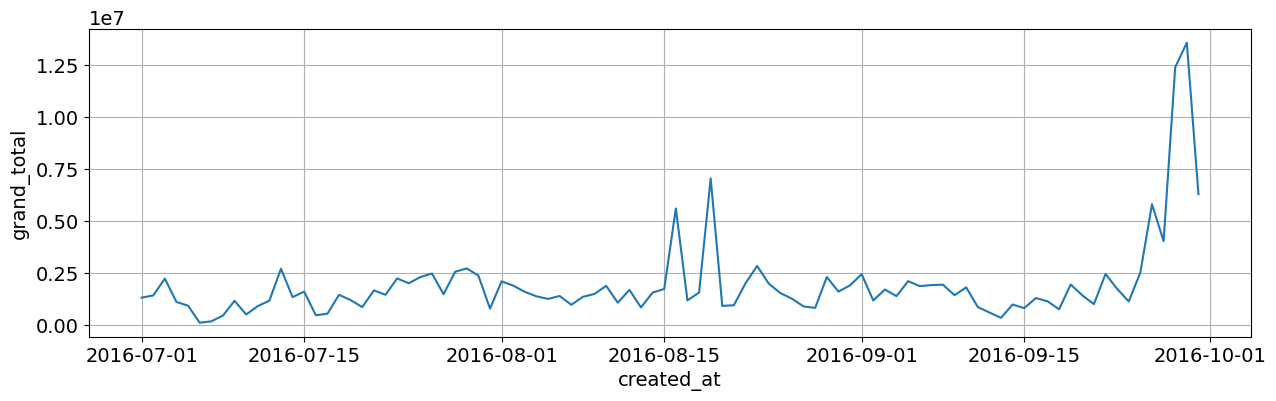

In [26]:
#Plotting graph between year and Total sales
sns.lineplot(x = "created_at" , y = "grand_total",data= p )
plt.show()

In [29]:
dt['Year'].unique()

array([2016.,   nan])

In [31]:
#Checking Dataset is stationary or not
results = adfuller(p['grand_total'])
print(results)

(0.6104802046066092, 0.9878711196444825, 2, 89, {'1%': -3.506057133647011, '5%': -2.8946066061911946, '10%': -2.5844100201994697}, 2486.611164202686)


In [32]:
#We can also print p-value,Test statistics and Critical values as follows
results = adfuller(p['grand_total'])
print('Test Statistics: %f' % results[0])
print('p-value: %f' % results[1])
print('Critical Values: ')
for key, value in results[4].items():
    print('\t%s: %.3f' % (key,value))

Test Statistics: 0.610480
p-value: 0.987871
Critical Values: 
	1%: -3.506
	5%: -2.895
	10%: -2.584
